<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Diego Pintor Ochoa, Lyha Espinosa García

**Fecha:** 07 de mayo de 2021.

**Expediente** : if72622, if721861.
**Profesor:** Oscar David Jaramillo Zuluaga.

# Tarea 10: Clase 23

[Liga al repositorio](https://github.com/PintorOD1997/ProyectoConjunto_LEspinosa_DPintor.git)

## Enunciado de tarea 
# Tarea

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
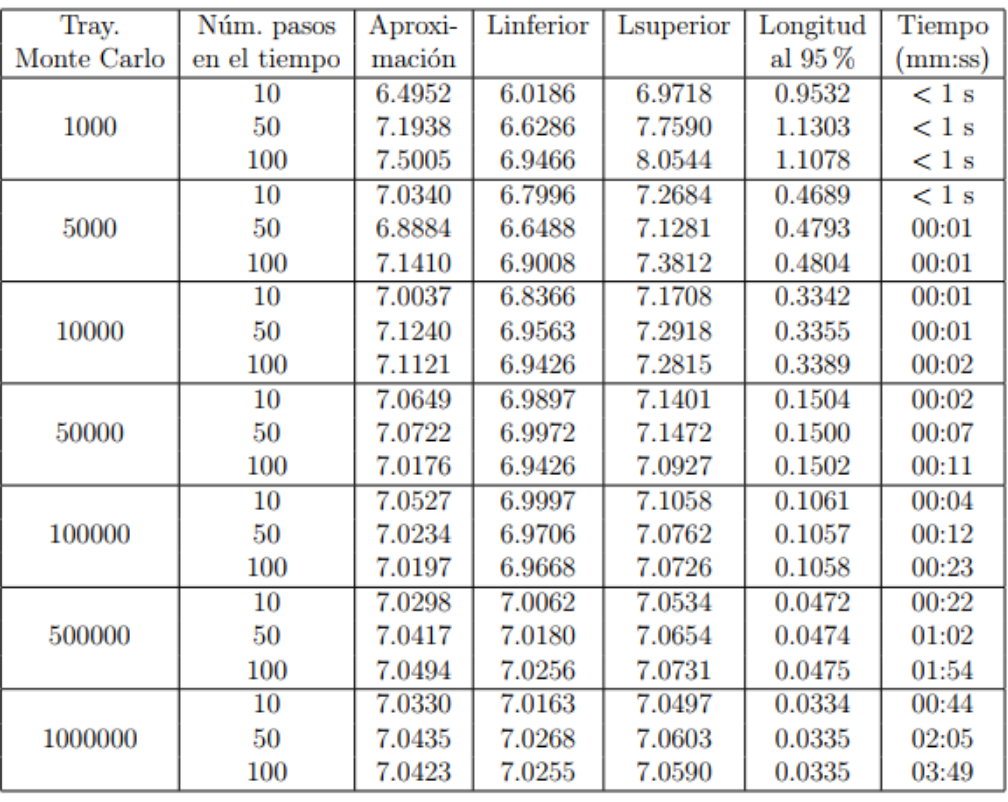

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

### Solución Lyha Espinosa

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from time import time
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns; sns.set()
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

## Call

In [3]:
def call_asiatica_trap(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato'):
    
    # Iniciar Tiempo
    tiempo_in = time()
    
    # precios mediante black and scholes
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t) #DataFrame de precios
    
    # precios promedio
    h = T/NbStep
    Av_t = np.cumsum(prices * (2+r*h+np.random.randn(NbStep,NbTraj)*sigma))*h/(2*T)
    
    strike = K
    # Calculamos el call
    valuacion = pd.DataFrame({'Prima': np.exp(-r*T)*np.fmax(Av_t - strike, 0).mean(axis=1)}, index=t)
    
    # intervalos de confianza
    conf = 0.95
    i = st.norm.interval(conf, loc = valuacion.iloc[-1].Prima, scale = valuacion.sem().Prima)
    
    
    tiempo_fin = time()
    tiempo_total = tiempo_fin - tiempo_in
    
    # regresar prima, intervalos de confianza, rango de intervalos  y tiempo
    return np.array([valuacion.iloc[-1].Prima,i[0],i[1],i[1]-i[0],tiempo_total])


In [4]:
# Valores de la opcion 
S0 = 100
K = 100
r = 0.1
sigma = 0.2
T = 1

# Trayectorias monte carlo
NbTraj = [1000,5000,10000,50000,100000,500000,1000000]

# Pasos en el tiempo
NbStep = [10,50,100]

In [5]:
call = list(map(lambda trayectorias:list(map(lambda pasos: 
                                             call_asiatica_trap(K,r,S0,trayectorias,pasos,sigma,T),NbStep)), NbTraj))

In [6]:
n = 3 # niveles por index

# indice posicion de cada rango
i1 =list(map(lambda i: int(i/n),range(7*n)))

# posicion de cada sub rango
i2 =list(map(lambda i: int(i%n),range(7*n)))

# index del data frame
indx = pd.MultiIndex(levels=[NbTraj,NbStep], codes=[i1, i2])

call_array = np.array([call[i1[i]][i2[i]] for i in range(len(i1))])

call_aprox = np.array([i[0] for i in call_array]) # aproximacion

# limite inferior
lim_inf = np.array([i[1] for i in call_array])

# limite superior
lim_sup = np.array([i[2] for i in call_array])

# rango de limites 
rango = np.array([i[3] for i in call_array])

# obtener tiempos
tiempos_call = np.array([i[4] for i in call_array])


# General DF
tabla_call = pd.DataFrame(index=indx,columns=['Aproximacion','Linferior','Lsuperior','Longitud 95%','Tiempo'])
tabla_call.index.names = (['Tray. Monte Carlo','Num. pasos en el tiempo'])
tabla_call['Aproximacion'] = call_aprox
tabla_call['Linferior'] = lim_inf
tabla_call['Lsuperior'] = lim_sup
tabla_call['Longitud 95%'] = rango
tabla_call['Tiempo'] = np.round(tiempos_call,2)

In [7]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
tabla_call

Aproximacion  Linferior  \
Tray. Monte Carlo Num. pasos en el tiempo                            
1000              10                              6.983      5.609   
                  50                              7.037      6.625   
                  100                             7.068      6.793   
5000              10                              6.833      5.493   
                  50                              7.062      6.643   
                  100                             7.011      6.736   
10000             10                              6.906      5.552   
                  50                              6.955      6.544   
                  100                             7.082      6.803   
50000             10                              6.917      5.560   
                  50                              7.016      6.602   
                  100                             7.134      6.853   
100000            10                              6.925      5.566   
                  50                              7.063      6.646   
                  100                             6.997      6.722   
500000            10                              6.897      5.544   
                  50                              7.017      6.603   
                  100                             7.017      6.741   
1000000           10                              6.903      5.549   
                  50                              6.992      6.580   
                  100                             7.020      6.744   

                                           Lsuperior  Longitud 95%  Tiempo  
Tray. Monte Carlo Num. pasos en el tiempo                                   
1000              10                           8.356         2.747    0.05  
                  50                           7.449         0.824    0.05  
                  100                          7.343         0.549    0.03  
5000              10                           8.172         2.679    0.05  
                  50                           7.482         0.839    0.09  
                  100                          7.287         0.551    0.17  
10000             10                           8.260         2.709    0.07  
                  50                           7.366         0.821    0.19  
                  100                          7.361         0.558    0.23  
50000             10                           8.273         2.713    0.36  
                  50                           7.431         0.829    0.84  
                  100                          7.415         0.563    1.43  
100000            10                           8.283         2.717    0.70  
                  50                           7.481         0.835    1.50  
                  100                          7.272         0.550    2.58  
500000            10                           8.249         2.705    3.23  
                  50                           7.431         0.829    8.98  
                  100                          7.292         0.552   15.94  
1000000           10                           8.256         2.707    6.59  
                  50                           7.405         0.826   15.52  
                  100                          7.296         0.552   32.16

## Put

In [8]:
def put_asiatica_trap(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato'):
    
    # Iniciar Tiempo
    tiempo_in = time()
    
    # precios mediante black and scholes
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t) #DataFrame de precios
    
    # precios promedio
    h = T/NbStep
    Av_t = np.cumsum(prices * (2+r*h+np.random.randn(NbStep,NbTraj)*sigma))*h/(2*T)
    
    strike = K
    # Calculamos put
    valuacion = pd.DataFrame({'Prima': np.exp(-r*T)*np.fmax(strike - Av_t , 0).mean(axis=1)}, index=t)
    
    # intervalos de confianza
    conf = 0.95
    i = st.norm.interval(conf, loc = valuacion.iloc[-1].Prima, scale = valuacion.sem().Prima)
    
    
    tiempo_fin = time()
    tiempo_total = tiempo_fin - tiempo_in
    
    # regresar prima, intervalos de confianza, rango de intervalos  y tiempo
    return np.array([valuacion.iloc[-1].Prima,i[0],i[1],i[1]-i[0],tiempo_total])

In [9]:
put = list(map(lambda trayectorias:list(map(lambda pasos: 
                                             put_asiatica_trap(K,r,S0,trayectorias,pasos,sigma,T),NbStep)), NbTraj))

In [10]:
n = 3 # niveles por index

# indice posicion de cada rango
i1 =list(map(lambda i: int(i/n),range(7*n)))

# posicion de cada sub rango
i2 =list(map(lambda i: int(i%n),range(7*n)))

# index del data frame
indx = pd.MultiIndex(levels=[NbTraj,NbStep], codes=[i1, i2])

put_array = np.array([put[i1[i]][i2[i]] for i in range(len(i1))])

put_aprox = np.array([i[0] for i in put_array]) # aproximacion

# limite inferior
lim_inf_p = np.array([i[1] for i in put_array])

# limite superior
lim_sup_p = np.array([i[2] for i in put_array])

# rango de limites 
rango = np.array([i[3] for i in put_array])

# obtener tiempos
tiempos_put = np.array([i[4] for i in put_array])


# General DF
tabla_put = pd.DataFrame(index=indx,columns=['Aproximacion','Linferior','Lsuperior','Longitud 95%','Tiempo'])
tabla_put.index.names = (['Tray. Monte Carlo','Num. pasos en el tiempo'])
tabla_put['Aproximacion'] = put_aprox
tabla_put['Linferior'] = lim_inf_p
tabla_put['Lsuperior'] = lim_sup_p
tabla_put['Longitud 95%'] = rango
tabla_put['Tiempo'] = np.round(tiempos_put,2)

In [11]:
tabla_put

Aproximacion  Linferior  \
Tray. Monte Carlo Num. pasos en el tiempo                            
1000              10                              1.819    -15.406   
                  50                              2.195     -5.277   
                  100                             2.050     -3.228   
5000              10                              2.246    -14.857   
                  50                              2.489     -4.958   
                  100                             2.362     -2.894   
10000             10                              2.180    -14.941   
                  50                              2.437     -5.013   
                  100                             2.336     -2.927   
50000             10                              2.239    -14.874   
                  50                              2.362     -5.096   
                  100                             2.340     -2.917   
100000            10                              2.233    -14.882   
                  50                              2.326     -5.137   
                  100                             2.349     -2.908   
500000            10                              2.222    -14.895   
                  50                              2.323     -5.139   
                  100                             2.354     -2.902   
1000000           10                              2.219    -14.900   
                  50                              2.333     -5.128   
                  100                             2.343     -2.914   

                                           Lsuperior  Longitud 95%  Tiempo  
Tray. Monte Carlo Num. pasos en el tiempo                                   
1000              10                          19.045        34.451    0.02  
                  50                           9.667        14.944    0.03  
                  100                          7.327        10.555    0.02  
5000              10                          19.349        34.206    0.06  
                  50                           9.936        14.895    0.09  
                  100                          7.617        10.511    0.15  
10000             10                          19.302        34.244    0.07  
                  50                           9.887        14.899    0.20  
                  100                          7.598        10.526    0.31  
50000             10                          19.353        34.227    0.35  
                  50                           9.819        14.915    0.86  
                  100                          7.597        10.514    1.37  
100000            10                          19.347        34.229    0.62  
                  50                           9.789        14.926    1.48  
                  100                          7.605        10.514    2.32  
500000            10                          19.340        34.235    2.86  
                  50                           9.785        14.924    7.24  
                  100                          7.611        10.514   12.20  
1000000           10                          19.338        34.238    6.74  
                  50                           9.794        14.923   15.39  
                  100                          7.601        10.515   26.63